In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
pkl_path = '/local/crv/acanberk/gpt-plan-benchmark/infos.pkl'

with open(pkl_path, 'rb') as f:
    info = pickle.load(f)

from typing import List, Dict, Tuple, Any, Optional
    


In [3]:
print(info['gt'][0].keys())

dict_keys(['chosen_decode_tokens', 'chosen_log_probs', 'entropy', 'layer_activations', 'top_k_decode_tokens', 'top_k_entropy', 'top_k_log_probs', 'response'])


In [4]:

def extract_plan_begin_idx(sequence_tokens : List[str], plan_start_str : str = "[PLAN]") -> int:
    for i in range(len(sequence_tokens), 0, -1):
        if plan_start_str in "".join(sequence_tokens[i:]):
            break
    return i

def extract_plan_all_tokens(sequence_tokens : List[str], sequence_data : List[Any]) -> np.array:
    begin_idx = extract_plan_begin_idx(sequence_tokens)
    return np.array(sequence_data[begin_idx:])

def extract_plan_step_tokens(sequence_tokens : List[str], sequence_data : List[Any]) -> np.array:
    begin_idx = extract_plan_begin_idx(sequence_tokens)
    plan_sequence_tokens = sequence_tokens[begin_idx:]
    result = []
    for j, tok in enumerate(plan_sequence_tokens[:-1]):
        if tok == '\n':
            result.append(sequence_data[begin_idx+j])
    return np.array(result)


def extract_nll(sequence_log_probs : List[float], sequence_tokens : List[str], mode="all"):

    begin_idx = extract_plan_begin_idx(sequence_tokens)

    if mode == 'step': # for only considering the logprob of each crucial step
        return -np.mean(extract_plan_step_tokens(sequence_tokens, sequence_log_probs))
    elif mode == 'all': # for considering logprob of all tokens
        return -np.mean(extract_plan_all_tokens(sequence_tokens, sequence_log_probs))
    else:
        raise NotImplementedError

def extract_entropy(sequence_entropy : List[float], sequence_tokens : List[str], mode="all"):

    begin_idx = extract_plan_begin_idx(sequence_tokens)

    if mode == 'step':
        return np.mean(extract_plan_step_tokens(sequence_tokens, sequence_entropy))
    elif mode == 'all':
        return np.mean(extract_plan_all_tokens(sequence_tokens, sequence_entropy))
    else:
        raise NotImplementedError


In [10]:
test_plan = info['gt'][0]
test_plan_tokens = test_plan['chosen_decode_tokens']
test_plan_log_probs = [x[0] for x in test_plan['top_k_log_probs']]
test_plan_entropy = test_plan['entropy']
begin_idx = extract_plan_begin_idx(test_plan_tokens)

print(f"plan length = {len(test_plan_tokens)}, plan_begin_idx = {begin_idx}")
print(f"plan = {test_plan_tokens[begin_idx:]}")
print(f"plan logprobs = {[f'{x:.1f}' for x in test_plan_log_probs[begin_idx:]]}")
print(f"plan entropy = {[f'{x:.2f}' for x in test_plan_entropy[begin_idx:]]}")

tokens_and_logprobs = list(zip(test_plan_tokens[begin_idx:], test_plan_log_probs[begin_idx-1:], test_plan_entropy[begin_idx-1:]))

tokens_after_newline = []
for i, tok in enumerate(test_plan_tokens[begin_idx:-1]):
    if tok == '\n':
        tokens_after_newline.append(tokens_and_logprobs[i+1])

#print tokens and logprob pairs
print("\n")
for token, logprob, entropy in tokens_and_logprobs:
    t = token if token != '\n' else '\\n'
    print(f"token={t}, logprob={logprob:.1f}, entropy={entropy:.2f}")


plan length = 1483, plan_begin_idx = 1400
plan = ['[', 'PL', 'AN', ']', '\n', 'un', 'stack', 'the', 'yellow', 'block', 'from', 'on', 'top', 'of', 'the', 'red', 'block', '\n', 'put', 'down', 'the', 'yellow', 'block', '\n', 'un', 'stack', 'the', 'red', 'block', 'from', 'on', 'top', 'of', 'the', 'blue', 'block', '\n', 'put', 'down', 'the', 'red', 'block', '\n', 'pick', 'up', 'the', 'yellow', 'block', '\n', 'stack', 'the', 'yellow', 'block', 'on', 'top', 'of', 'the', 'red', 'block', '\n', 'pick', 'up', 'the', 'blue', 'block', '\n', 'stack', 'the', 'blue', 'block', 'on', 'top', 'of', 'the', 'yellow', 'block', '\n', '[', 'PL', 'AN', 'END', ']', '\n']
plan logprobs = ['-0.0', '-0.0', '-0.0', '-0.0', '-0.3', '-0.0', '-0.0', '-0.9', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.2', '-0.0', '-0.0', '-0.2', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.2', '-0.0', '-0.0', '-0.1', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.1', '-0.0', '-0.0', '-0.0', '-0.0', '-

In [15]:
from rich.console import Console
from rich.table import Table
import numpy as np

def get_nll_all(info):
    return extract_nll([x[0] for x in info['top_k_log_probs']], info['chosen_decode_tokens'])

def get_nll_steps(info):
    return extract_nll([x[0] for x in info['top_k_log_probs']], info['chosen_decode_tokens'], mode='step')

def get_entropy_all(info):
    return extract_entropy(info['entropy'], info['chosen_decode_tokens'])

def get_entropy_steps(info):
    return extract_entropy(info['entropy'], info['chosen_decode_tokens'], mode='step')

def candidates_from_info(info, idx):
    return {'gt': info['gt'][idx], 
            'gpt3': info['gpt3'][idx],
            'aug0': info['aug'][idx]['aug_info0'], 
            'aug1': info['aug'][idx]['aug_info1'], 
            'aug2': info['aug'][idx]['aug_info2']}

metric_functions = {'nll_all': get_nll_all, 
                    'nll_step': get_nll_steps, 
                    'entropy_all': get_entropy_all, 
                    'entropy_step': get_entropy_steps}
metrics = metric_functions.keys()
metric_lowest_counts = {}

correct, n_not_correct = 0, 0

for metric in metrics:
    metric_lowest_counts[metric] = np.zeros(5)

for idx in range(len(info['gt'])):

    candidates = candidates_from_info(info, idx)

    for metric, metric_fn in metric_functions.items():

        vals = []
        for i, (candidate_name, candidate_info) in enumerate(candidates.items()):
            metric_val = metric_fn(candidate_info)
            vals.append(metric_val)

        lowest_idx = np.argmin(vals)
        metric_lowest_counts[metric][lowest_idx] += 1

title_str = f"metric | "  
for candidate_name in candidates.keys():
    title_str += f"{candidate_name} | "

print(title_str)
for metric, counts in metric_lowest_counts.items():
    counts = np.array(counts)
    counts /= np.sum(counts)
    metric_str = f"{metric} | "
    for count in counts:
        metric_str += f"{count:.2f} | "
    print(metric_str)


metric | gt | gpt3 | aug0 | aug1 | aug2 | 
nll_all | 0.55 | 0.44 | 0.00 | 0.01 | 0.00 | 
nll_step | 0.49 | 0.42 | 0.03 | 0.03 | 0.02 | 
entropy_all | 0.55 | 0.45 | 0.00 | 0.00 | 0.00 | 
entropy_step | 0.55 | 0.43 | 0.01 | 0.01 | 0.00 | 


1400 1400 1483 1477
1417 1417 1483 1483
1423 1423 1451 1468
1371 1371 1435 1410
1372 1372 1419 1419
1399 1399 1463 1463
1388 1388 1435 1435
1388 1388 1435 1435
1371 1371 1435 1429
1385 1385 1451 1432
1415 1415 1479 1479
1401 1401 1467 1448
1412 1412 1483 1487
1416 1416 1487 1487
1438 1438 1483 1509
1401 1401 1467 1446
1388 1388 1416 1454
1360 1360 1388 1388
1325 1325 1360 1353
1340 1340 1411 1379
1391 1391 1455 1443
1420 1420 1455 1484
1373 1373 1439 1419
1364 1364 1411 1399
1376 1376 1411 1423
1356 1356 1439 1415
1403 1403 1431 1486
1396 1396 1443 1424
1363 1363 1427 1402
1385 1385 1451 1432
1415 1415 1479 1479
1412 1412 1495 1487
1443 1443 1507 1526
1440 1440 1523 1504
1440 1440 1523 1504
1456 1456 1539 1539
1448 1448 1476 1531
1396 1396 1460 1435
1377 1377 1460 1422
1443 1443 1507 1507
1429 1429 1495 1512
1415 1415 1467 1490
1400 1400 1483 1452
1420 1420 1467 1472
1412 1412 1495 1495
1412 1412 1495 1495
1445 1445 1499 1511
1416 1416 1499 1486
1408 1408 1455 1474
1401 1401 1467 1448


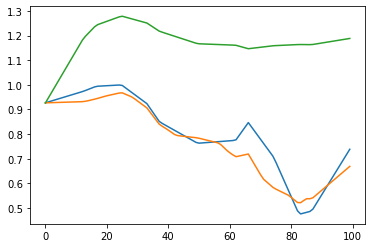

In [26]:
import matplotlib.pyplot as plt

gt_plan_entropies = []
gpt3_plan_entropies = []
aug_plan_entropies = []

gt_plan_nlls = []
gpt3_plan_nlls = []
aug_plan_nlls = []

for idx in range(50):
    # idx = np.random.randint(50)

    gt_info = info['gt'][idx]
    gpt3_info = info['gpt3'][idx]
    aug_info = info['aug'][idx][f'aug_info0']

    #extract the plan start index
    gt_plan_start_idx = extract_plan_begin_idx(gt_info['chosen_decode_tokens'])
    gpt3_plan_start_idx = extract_plan_begin_idx(gpt3_info['chosen_decode_tokens'])
    aug_plan_start_idx = extract_plan_begin_idx(aug_info['chosen_decode_tokens'])

    assert gt_plan_start_idx == gpt3_plan_start_idx == aug_plan_start_idx
    plan_start_idx = gt_plan_start_idx

    print(gt_plan_start_idx, gpt3_plan_start_idx, len(gt_info['chosen_decode_tokens']), len(gpt3_info['chosen_decode_tokens']))

    # gt_plan_entropy = extract_plan_all_tokens(gt_info['chosen_decode_tokens'], gt_info['entropy'])
    # gpt3_plan_entropy = extract_plan_all_tokens(gpt3_info['chosen_decode_tokens'], gpt3_info['entropy'])
    # aug_plan_entropy = extract_plan_all_tokens(aug_info['chosen_decode_tokens'], aug_info['entropy'])
    # gt_plan_nll = extract_plan_all_tokens(gt_info['chosen_decode_tokens'], gt_info['chosen_log_probs'])
    # gpt3_plan_nll = extract_plan_all_tokens(gpt3_info['chosen_decode_tokens'], gpt3_info['chosen_log_probs'])
    # aug_plan_nll = extract_plan_all_tokens(aug_info['chosen_decode_tokens'], aug_info['chosen_log_probs'])

    gt_plan_entropy = extract_plan_step_tokens(gt_info['chosen_decode_tokens'], gt_info['entropy'])
    gpt3_plan_entropy = extract_plan_step_tokens(gpt3_info['chosen_decode_tokens'], gpt3_info['entropy'])
    aug_plan_entropy = extract_plan_step_tokens(aug_info['chosen_decode_tokens'], aug_info['entropy'])
    gt_plan_nll = extract_plan_step_tokens(gt_info['chosen_decode_tokens'], gt_info['chosen_log_probs'])
    gpt3_plan_nll = extract_plan_step_tokens(gpt3_info['chosen_decode_tokens'], gpt3_info['chosen_log_probs'])
    aug_plan_nll = extract_plan_step_tokens(aug_info['chosen_decode_tokens'], aug_info['chosen_log_probs'])

    gt_plan_entropies.append(gt_plan_entropy)
    gpt3_plan_entropies.append(gpt3_plan_entropy)
    aug_plan_entropies.append(aug_plan_entropy)

    gt_plan_nlls.append(gt_plan_nll)
    gpt3_plan_nlls.append(gpt3_plan_nll)
    aug_plan_nlls.append(aug_plan_nll)

    names = ['ground truth', 'generated', 'augmented']
    entropies = [gt_plan_entropy, gpt3_plan_entropy, aug_plan_entropy]
    nlls = [gt_plan_nll, gpt3_plan_nll, aug_plan_nll]

    # for name, entropy, nll in zip(names, entropies, nlls):
    #     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    #     #plot the entropy of the plan
    #     axs[0].bar(range(len(entropy)), entropy, label='gt')
    #     axs[0].set_title(f'entropy of {name} plan: {np.mean(entropy):.3f}')
    #     axs[1].bar(range(len(nll)), [-x for x in nll], label='gt')
    #     axs[1].set_title(f'nll of {name} plan: {np.mean([-x for x in nll]):.3f}')

    #     #change the max_y of the plots to 10
    #     axs[0].set_ylim([0, 2])
    #     axs[1].set_ylim([0, 10])


    #     plt.show()
    # break

import numpy as np

print(gt_plan_entropies)


def expand_array(arr, new_length):
    old_indices = np.linspace(0, len(arr)-1, len(arr))  # old indices
    new_indices = np.linspace(0, len(arr)-1, new_length)  # new indices
    new_arr = np.interp(new_indices, old_indices, arr)  # interpolate
    return new_arr

gt_plan_entropies = np.array([expand_array(arr, 100) for arr in gt_plan_entropies]).mean(axis=0)
gpt3_plan_entropies = np.array([expand_array(arr, 100) for arr in gpt3_plan_entropies]).mean(axis=0)
aug_plan_entropies = np.array([expand_array(arr, 100) for arr in aug_plan_entropies]).mean(axis=0)

#shapes
print(gt_plan_entropies.shape, gpt3_plan_entropies.shape, aug_plan_entropies.shape)
#plot the three lines
plt.plot(gt_plan_entropies, label='ground truth')
plt.plot(gpt3_plan_entropies, label='generated')
plt.plot(aug_plan_entropies, label='augmented')



In [9]:

print("FROM GROUND TRUTH")
#write the prints above more cleanly with for loops
for i in range(plan_start_idx, len(gt_info['chosen_decode_tokens'])):
    top_k = gt_info['top_k_decode_tokens'][i-1]
    top_k_probs = gt_info['top_k_log_probs'][i-1]
    # if the top token is not the chosen decode token then print it in red
    if top_k[0] != gt_info['chosen_decode_tokens'][i]:
        print("**** ERROR ****")
    print(gt_info['chosen_decode_tokens'][i], " " * (20 - len(gt_info['chosen_decode_tokens'][i])), f"{gt_info['entropy'][i-1]:.4f}", "top k:", [(tok, f"{prob:.4f}") for tok, prob in zip(top_k, top_k_probs)])

print("#"*100)
print("\n\n\n")

print("FROM AUGMENTED RESULT")
for i in range(plan_start_idx, len(aug_info['chosen_decode_tokens'])):
    top_k = aug_info['top_k_decode_tokens'][i-1]
    top_k_probs = aug_info['top_k_log_probs'][i-1]
    # if the top token is not the chosen decode token then print it in red
    if top_k[0] != aug_info['chosen_decode_tokens'][i]:
        print("**** ERROR ****")
    print(aug_info['chosen_decode_tokens'][i], " " * (20 - len(aug_info['chosen_decode_tokens'][i])), f"{aug_info['entropy'][i-1]:.4f}", "top k:", [(tok, f"{prob:.4f}") for tok, prob in zip(top_k, top_k_probs)])

print("#"*100)
print("\n\n\n")

print("FROM GENERATED RESULT")

for i in range(gpt3_plan_start_idx, len(gpt3_info['chosen_decode_tokens'])):
    top_k = gpt3_info['top_k_decode_tokens'][i-1]
    top_k_probs = gpt3_info['top_k_log_probs'][i-1]
    print(gpt3_info['chosen_decode_tokens'][i], " " * (20 - len(gpt3_info['chosen_decode_tokens'][i])), f"{gpt3_info['entropy'][i-1]:.4f}", "top k:", [(tok, f"{prob:.4f}") for tok, prob in zip(top_k, top_k_probs)])

print("#"*100)


FROM GROUND TRUTH
[                     -9.8282 top k: [('[', '-0.0079'), ('un', '-6.5079'), ('pick', '-6.8204'), ('\\', '-6.8829'), ('I', '-7.6251'), ('[', '-8.2267'), ('P', '-8.2423'), ('My', '-8.9845'), ('p', '-8.9923'), ('plan', '-9.1095'), ('stack', '-9.2032'), ('Un', '-9.3282'), ('Stack', '-9.5470'), ('(', '-9.5626'), ('*', '-9.6017')]
PL                    -18.2462 top k: [('PL', '-0.0001'), ('pl', '-11.4064'), ('PRO', '-11.4455'), ('Plan', '-11.9923'), ('PL', '-12.2033'), ('RE', '-12.2423'), ('P', '-12.3048'), ('plan', '-12.4376'), ('PRE', '-12.5783'), ('ST', '-12.6564'), ('Pl', '-12.7970'), ('STR', '-12.8986'), ('PR', '-12.9142'), ('SE', '-13.0392'), ('EX', '-13.0861')]
AN                    -17.1953 top k: [('AN', '-0.0000'), (']', '-11.9844'), ('N', '-12.9063'), ('ANT', '-13.1485'), ('AT', '-13.8125'), ('\n', '-14.1016'), ('IN', '-14.1094'), ('ACE', '-14.4922'), ('...', '-14.7891'), ('AC', '-14.8125'), ('1', '-14.9531'), ('AND', '-15.0391'), ('OT', '-15.1485'), ('UN', '-15.1